# Use pure tensorflow tensor datastructure to build the Neural Network - No Auto Differentiation yet.

In [43]:
# All posible imports
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error

# Utility function for 3D plot
We will be using this 3D plot in order to plot the real values of y with respect to the predicted values of y. This will help us in understading how those two values are related and how they change with or without activation function.

In [44]:
# Utility function to plot 3D Graphs
def plot_3d(comp, title, X, y, y_pred=None):
    X_tnse = TSNE(n_components=comp, random_state=123).fit_transform(X)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if y_pred is not None:
        ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred, label='y_pred', marker='v')
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y, label='y_true')
    ax.set_title(title)
    plt.legend()
    plt.show()

# Generating Sample data 3 inputs & 2 output

In [45]:
n = 200

# We need to take 3 inputs
inputs_dimensions = 3

# We need to have 2 outputs
output_dimensions = 2

# Setup some random seed
tf.random.set_seed(3)

# Generating X with 3 dimentions
X = tf.random.uniform((n, inputs_dimensions), -1, 1)

# Generating the value of the y_true
weights_true = tf.constant([[2., -5., 9.], [-1., 4., -5.]], dtype=tf.float32)
bias_true = tf.constant([[1], [-1]], dtype=tf.float32)

y_true = tf.matmul(9 * X ** 2, weights_true, transpose_b=True) + tf.matmul(X, weights_true, transpose_b=True) + tf.transpose(bias_true)

print('Sample Value for X:' + str(X[:3]))
print('Sample Value for y:'+ str(y_true[:3]))

Sample Value for X:tf.Tensor(
[[-0.73267365  0.13570619 -0.00733662]
 [-0.9662695   0.00908351  0.4974625 ]
 [-0.73932624 -0.32877016  0.30385542]], shape=(3, 3), dtype=float32)
Sample Value for y:tf.Tensor(
[[  7.628318   -3.8585553]
 [ 40.346657  -22.020931 ]
 [ 16.35329    -8.277992 ]], shape=(3, 2), dtype=float32)


# Plotting the data in a 3-Dimentional Plane

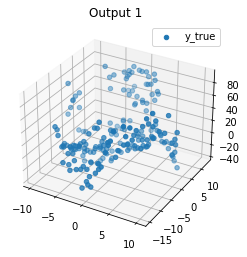

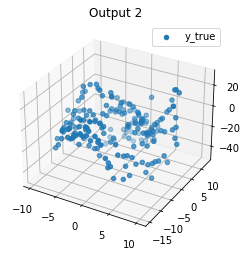

In [46]:
plot_3d(2, 'Output 1', X, y_true[:,0])
plot_3d(2, 'Output 2', X, y_true[:,1])

# Hyperparameters - Various Parameters that we will be using

In [47]:
# Number of Iterations
epochs = 200

# Learning rate of the algorithm
learning_rate = 0.01

# Inputs and outputs size. i.e 2 and 3 relatively
inputs = X.shape[1]
outputs = y_true.shape[1]

print("Number of inputs"+str(inputs))
print("Number of outputs"+str(outputs))

Number of inputs3
Number of outputs2


# Activation function as RELU

In [48]:
class Relu:
    def __init__(self):
        self.input = tf.constant([], dtype=tf.float32)

    def forward(self, input):
        self.input = input
        self.output = tf.clip_by_value(self.input, clip_value_min=0, clip_value_max=tf.float32.max)
        return self.output
  
    # If input is less than 0, derivative is 0. If input is greater than 0, derivative is 1
    def backward(self, upstream_gradient):
        return tf.where((self.input > 0), upstream_gradient, 0)
  
    # No update needed to ReLU members
    def update(self, lr):
        return

    def __str__(self):
        return 'ReLu'

# Mean Squared Error

In [49]:
# Mean Squared Error
class MSE:
    def __init__(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true
  
    def get_error(self):
        n = self.y_true.shape[0]
        return ((self.y_pred - self.y_true) ** 2) / n
  
    def backward(self):
        n = self.y_true.shape[0]
        self.gradient = 2.0 * (self.y_pred - self.y_true) / n
        return self.gradient

# Layers of Neural Network

In [50]:
class Layer:
    def __init__(self, no_input_nodes=1, no_output_nodes=1, activation=None):
        self.no_input_nodes = no_input_nodes
        self.no_output_nodes = no_output_nodes
        # Init layer with random weights and bias
        self.weights = tf.random.uniform((no_input_nodes, no_output_nodes), -1, 1)
        self.bias = tf.random.uniform((1, 1), -1, 1)
        self.X = tf.zeros([no_input_nodes])
        # Set activation function
        if activation == 'relu':
            self.activation = Relu()
        else: 
            self.activation = None
  
    def forward(self, X):
        self.X = X
        self.Z = tf.matmul(X, self.weights) + tf.transpose(self.bias)
        # Pass output to activation function
        if self.activation == None:
            return self.Z 
        else:
            return self.activation.forward(self.Z)

    # Refered for math resource: https://www.kdnuggets.com/2019/08/numpy-neural-networks-computational-graphs.html
    def backward(self, upstream_gradient):
        curr_upstream_gradient = upstream_gradient
        # Backpropagation
        if self.activation != None:
            curr_upstream_gradient = self.activation.backward(curr_upstream_gradient)

        # Adjust Gradient and aloss
        self.dJdW = tf.matmul(self.X, curr_upstream_gradient, transpose_a=True)
        self.dJdb = tf.reduce_sum(curr_upstream_gradient, 1)
        self.dJdX = tf.matmul(curr_upstream_gradient, self.weights, transpose_b=True)
        return self.dJdX

    # Update weight and bias
    def update(self, lr):
        self.weights = self.weights - lr * self.dJdW
        self.bias = self.bias - lr * self.dJdb

    def __str__(self):
        return 'Layer: ({},{}) Activation Function: {}\nInputs:\n{}\nWeights:\n{}\nBias:{}'.format(self.no_input_nodes, self.no_output_nodes, self.activation, self.X[:2], self.weights, self.bias)

# Neural Network Model

In [51]:
class Model:
    def __init__(self, num_inputs=3, num_hidden=[2], num_outputs=2, activation=None):
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs

        layers = [self.num_inputs] + self.num_hidden + [self.num_outputs]

        self.layers = []
        for i in range(len(layers[:-1])):
          # Don't add activation function to last layer because this is a regression problem
            if i == len(layers[:-1]) - 1:
                self.layers.append(Layer(layers[i], layers[i + 1], activation=None))
            else:
                self.layers.append(Layer(layers[i], layers[i + 1], activation))

        print('Neural Network Architecture')
        for i, layer in enumerate(self.layers):
            print('Layer {}'.format(i))
            print(layer)
        print()

    def forward(self, inputs):
        curr_out = inputs
        for l in self.layers:
            curr_out = l.forward(curr_out)
        return curr_out
  
    def backward(self, y_pred, y_true):
        # Start with gradient from loss function wrt prediction
        mse = MSE(y_pred, y_true)
        error = mse.get_error()
        print('Error: ', mean_squared_error(y_true, y_pred))
        loss_gradient = mse.backward()

        # Pass dJ/dy to last layer of network and compute gradients at each layer backwards
        gradient = loss_gradient
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)
    
    def update(self, lr):
        for layer in self.layers:
            layer.update(lr)

    # Training loop over # of epochs
    def fit(self, X, y_true, epochs):
        for i in range(epochs):
            y_pred = self.forward(X)
            self.backward(y_pred, y_true)
            self.update(learning_rate)

    def __str__(self):
        s = [str(layer) for layer in self.layers]
        return '\n'.join(s)

# Training with Activation function RELU

In [52]:
nn = Model(num_inputs=inputs, num_hidden=[4, 3], num_outputs=outputs, activation='relu')
nn.fit(X, y_true, epochs)
y_pred = nn.forward(X)

err = mean_squared_error(y_true, y_pred)
print('Final MSE: {}'.format(err))

Neural Network Architecture
Layer 0
Layer: (3,4) Activation Function: ReLu
Inputs:
[0. 0.]
Weights:
[[-0.6108563  -0.6274359  -0.75197625 -0.6338546 ]
 [ 0.14360666  0.58127475  0.76337886 -0.52446985]
 [-0.65584254 -0.26099324 -0.03134227  0.14001346]]
Bias:[[-0.29354858]]
Layer 1
Layer: (4,3) Activation Function: ReLu
Inputs:
[0. 0.]
Weights:
[[ 0.27853966 -0.34147358 -0.5273199 ]
 [ 0.38047528  0.66011167 -0.8229246 ]
 [-0.34575987  0.77592945 -0.79747796]
 [ 0.06473207 -0.8865769   0.36763716]]
Bias:[[-0.7752714]]
Layer 2
Layer: (3,2) Activation Function: None
Inputs:
[0. 0.]
Weights:
[[ 0.6908052   0.6602192 ]
 [ 0.21945977 -0.76762486]
 [ 0.19691539 -0.4867468 ]]
Bias:[[-0.9005773]]

Error:  876.0688
Error:  876.0277
Error:  875.9863
Error:  875.9447
Error:  875.9033
Error:  875.8609
Error:  875.8187
Error:  875.776
Error:  875.7338
Error:  875.692
Error:  875.6488
Error:  875.6061
Error:  875.5587
Error:  875.51086
Error:  875.46204
Error:  875.41284
Error:  875.36255
Error:  87

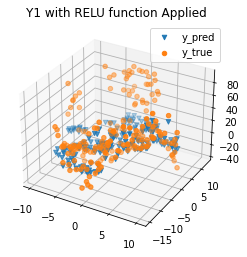

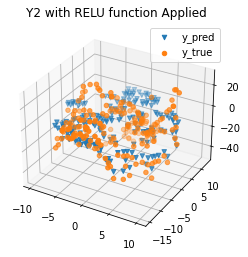

In [53]:
# Replotting the sample with y_true and y_pred
plot_3d(2, 'Y1 with RELU function Applied', X, y_true[:,0], y_pred[:,0])
plot_3d(2, 'Y2 with RELU function Applied', X, y_true[:,1], y_pred[:,1])

# Training without Activation Function

In [55]:
nn = Model(num_inputs=inputs, num_hidden=[4, 3], num_outputs=outputs, activation='')
nn.fit(X, y_true, epochs)
y_pred = nn.forward(X)

err = mean_squared_error(y_true, y_pred)
print('Final MSE: {}'.format(err))

Neural Network Architecture
Layer 0
Layer: (3,4) Activation Function: ReLu
Inputs:
[0. 0.]
Weights:
[[-0.17057347  0.73296833 -0.5045359  -0.7130058 ]
 [-0.4088936  -0.8155649  -0.19022894 -0.74012804]
 [ 0.43627167 -0.55135655 -0.20586038 -0.8750944 ]]
Bias:[[0.05005312]]
Layer 1
Layer: (4,3) Activation Function: ReLu
Inputs:
[0. 0.]
Weights:
[[ 0.09780073  0.35220718  0.67315054]
 [-0.7525151  -0.05943418 -0.91748786]
 [ 0.7131665  -0.21557641  0.88550806]
 [ 0.9157891   0.8755138   0.11674094]]
Bias:[[0.43070173]]
Layer 2
Layer: (3,2) Activation Function: None
Inputs:
[0. 0.]
Weights:
[[ 0.07060122 -0.3462417 ]
 [ 0.85405445 -0.40546417]
 [ 0.62723804 -0.42616296]]
Bias:[[0.5821588]]

Error:  829.6891
Error:  807.7584
Error:  763.7523
Error:  657.6015
Error:  403.07062
Error:  337.05792
Error:  590.105
Error:  306.52676
Error:  306.19778
Error:  619.54675
Error:  371.12274
Error:  200.88602
Error:  331.49768
Error:  289.6996
Error:  666.7413
Error:  486.26508
Error:  181.11528
Error

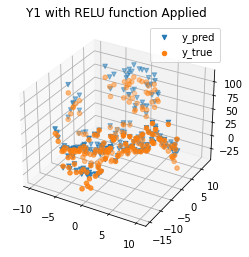

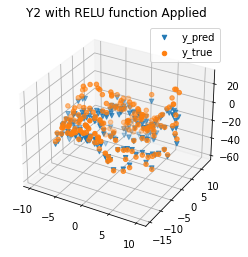

In [56]:
# Replotting the sample with y_true and y_pred
plot_3d(2, 'Y1 with RELU function Applied', X, y_true[:,0], y_pred[:,0])
plot_3d(2, 'Y2 with RELU function Applied', X, y_true[:,1], y_pred[:,1])